# Exploration of measured galaxy pitch angle variation

We have reason to suspect that our errors on galaxy pitch angle are incorrect. This notebook is an exploration of this problem.

## TL;DR
The problem seems to arise when we only pick up a subset of the available arms, a subsection of an arm or some combination of the above. Galaxies show large inter-arm variances in pitch angle (though potentially small intra-arm variance, interestingly), therefore different combinations of detected arms can produce large variances in reported "Length-weighted pitch angle" ($\phi_{\text{LW}}$).

Define the error on $\phi_{\text{LW}}$, $\sigma_{\phi_{\text{LW}}}$, to be the sample variance of the pitch angle of the galaxy's identified arms .

In [1]:
print('Performing initial setup 📖')
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import lib.galaxy_utilities as gu
from gzbuilderspirals.oo import Pipeline
from gzbuilderspirals import get_drawn_arms
import pandas as pd
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

Performing initial setup 📖


In [2]:
plt.style.use('seaborn-dark')
data = np.load('lib/duplicate_galaxies.npy')

Select a galaxy to explore:

In [3]:
# test galaxy from paper (dr8id 588023240206516423) has index 94
gal_index = 59
gal_dr8id = None

In [4]:
if gal_dr8id is not None:
    gal_index = np.where(dr8id == gal_dr8id)[0][0]
dr8id, ss_id, val_id = data[gal_index]
print(dr8id, ss_id, val_id)

587742062121582703 20902065 21686594


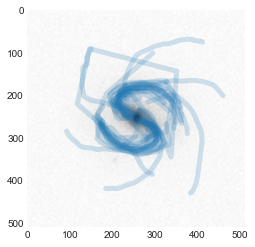

In [5]:
gal, angle = gu.get_galaxy_and_angle(ss_id)
pic_array, _ = gu.get_image(gal, ss_id, angle)

all_cls = gu.classifications.query(
    '(subject_ids == {}) or (subject_ids == {})'.format(
        ss_id, val_id
    )
)
drawn_arms_all = get_drawn_arms(
    (ss_id, val_id),
    all_cls
)
plt.imshow(pic_array)
for a in drawn_arms_all:
        plt.plot(*a.T, '-', c='C0', alpha=0.2, linewidth=5)

Given all the 60 classifications, the aggregated log-spirals look like:

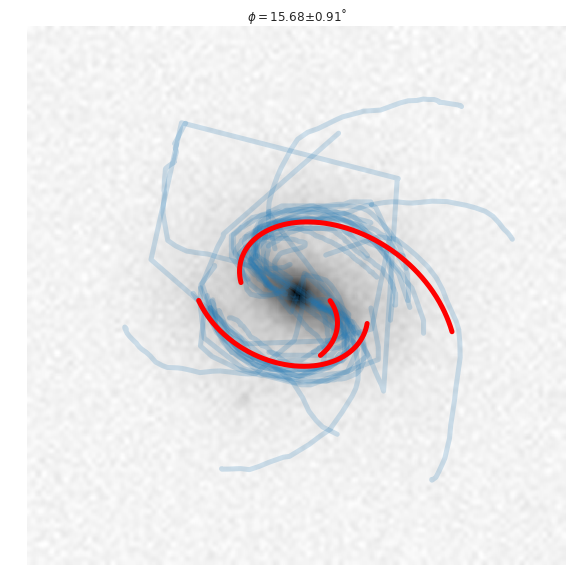

In [6]:
drawn_arms_all = get_drawn_arms(
    (ss_id, val_id),
    all_cls
)
p_all = Pipeline(drawn_arms_all, phi=angle, ba=gal['PETRO_BA90'],
             image_size=512, parallel=True)
arms_all = p_all.get_arms()
gal_pa = p_all.get_pitch_angle(arms_all)

plt.figure(figsize=(8, 8))
for b in drawn_arms_all:
        plt.plot(*b.T, '-', c='C0', alpha=0.2, linewidth=5)
for a in arms_all:
    plt.plot(*a.reprojected_log_spiral.T, 'r', linewidth=5)
plt.figure
plt.imshow(pic_array, cmap='gray_r')
plt.axis('off');
plt.tight_layout()
plt.title('$\phi = {:.2f} ± {:.2f}˚$'.format(
    *gal_pa
));

Denote the pitch angle for each of these arms as $\phi_{60}$ and the length-weighted pitch angle for the combined galaxy as 

$$\Phi_{60} = \frac{\sum_{i = 0}^{n} L_i\phi_{60, i}}{\sum_{i = 0}^{n} L_i},$$

where $L_i$ is the length of the $i^\text{th}$ arm.

Now let's randomly choose 30 classifications from the pool and observe the resulting spirals (and repeat `N_SPLITS` times). The distribution of pitch angles for each arm in each split will be denoted $\phi_{30}$, and each split's combined pitch angle ($\Phi_{30}$) calculated as above.

In [7]:
N_SPLITS = 50

In [8]:
ss = ShuffleSplit(n_splits=N_SPLITS, test_size=0.5, random_state=0)
pas = np.zeros((N_SPLITS, 2))
arms = []
for i, (train_index, _) in enumerate(ss.split(all_cls)):
    if i%10 == 0:
        print('Calculating split {}/{}'.format(i, N_SPLITS))
    drawn_arms = get_drawn_arms(
        (ss_id, val_id),
        all_cls.iloc[train_index]
    )
    p = Pipeline(drawn_arms, phi=angle, ba=gal['PETRO_BA90'],
                 image_size=512, parallel=True)
    arms.append(p.get_arms())

Calculating split 0/50
Calculating split 10/50
Calculating split 20/50
Calculating split 30/50
Calculating split 40/50


The log spirals for these splits look like:

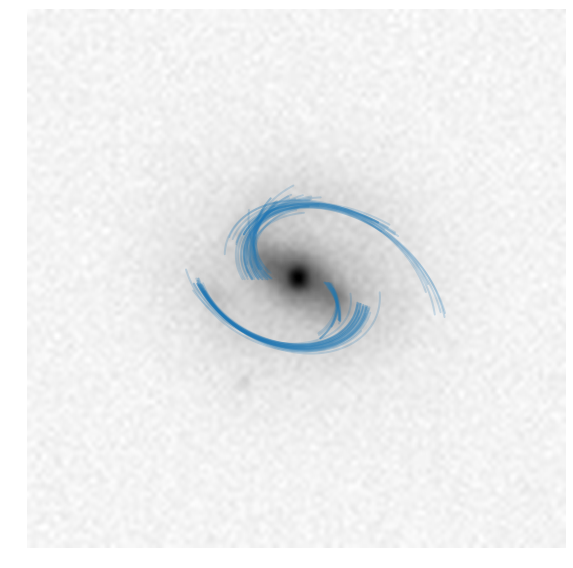

In [9]:
plt.figure(figsize=(8, 8))
tpl_arms = []
for i, group in enumerate(arms):
    for arm in group:
        plt.plot(*arm.reprojected_log_spiral.T, 'C0', alpha=0.2, linewidth=2)
    pas[i] = p.get_pitch_angle(arms=group)
plt.imshow(pic_array, cmap='gray_r')
plt.axis('off');
plt.tight_layout()

How does this population of pitch angles compare to the arms from all classifications combined?

/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


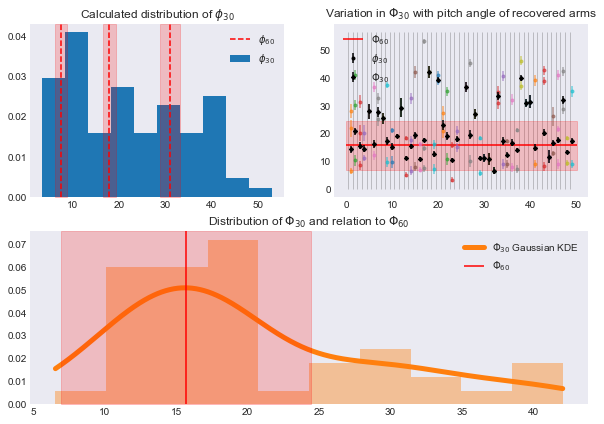

In [10]:
plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.hist([i.pa for g in arms for i in g], density=True, zorder=1, label='$\phi_{30}$')
lims = plt.gca().get_ylim()
for arm in arms_all:
    plt.vlines(arm.pa, 0, lims[1], color='r', linestyle='--')
    plt.fill_betweenx([0, lims[1]], arm.pa - arm.sigma_pa, arm.pa + arm.sigma_pa, color='r', alpha=0.2, zorder=2)
plt.plot([], [], 'r--', label='$\phi_{60}$')
plt.ylim(lims)
plt.legend()
plt.title('Calculated distribution of $\phi_{30}$')

plt.subplot(222)
all_pas = []
all_combs = []
for i, group in enumerate(arms):
    comb_pa = p.get_pitch_angle(group)
    all_combs += [comb_pa[0]]

for i, group in enumerate(arms):
    for arm in group:
        all_pas.append(arm.pa)
        plt.errorbar(i, arm.pa, yerr=arm.sigma_pa, fmt='.', c='C{}'.format(i%10), alpha=0.6, zorder=2)
    comb_pa = p.get_pitch_angle(group)
    plt.errorbar(i, comb_pa[0], yerr=comb_pa[1], fmt='kD', zorder=3, markersize=3)

plt.errorbar([], [], [],  fmt='k.', label='$\phi_{30}$')
plt.errorbar([], [], [],  fmt='kD', markersize=3, label='$\Phi_{30}$')
plt.hlines(gal_pa[0], 0, 50, color='r', label=r'$\Phi_{60}$', zorder=1)
plt.fill_between(
    [0, 50], gal_pa[0] - np.nanstd(all_combs), gal_pa[0] + np.nanstd(all_combs),
    color='r', alpha=0.2, zorder=1
)
plt.vlines(np.arange(len(arms) - 1) + 0.5, 0, max(plt.ylim()), color='k', zorder=0, alpha=0.4, linewidth=0.5)
plt.title('Variation in $\Phi_{30}$ with pitch angle of recovered arms')
plt.legend()

plt.subplot2grid((2, 1), (1, 0))
kde = st.gaussian_kde(np.array(all_combs)[~np.isnan(all_combs)], 'silverman')
_, bins, _ = plt.hist(all_combs, density=True, color='C1', alpha=0.4)
xx = np.linspace(bins.min(), bins.max(), 1000)
plt.plot(xx, kde(xx), color='C1', linewidth=5, label='$\Phi_{30}$ Gaussian KDE', zorder=1)
lims = plt.gca().get_ylim()
plt.fill_betweenx(
    [0, lims[1]], gal_pa[0] - np.nanstd(all_combs), gal_pa[0] + np.nanstd(all_combs), color='r', alpha=0.2, zorder=2
)
plt.vlines(gal_pa[0], 0, lims[1], color='r', zorder=2, label='$\Phi_{60}$')
plt.ylim(lims)
plt.legend()
plt.title(r'Distribution of $\Phi_{30}$ and relation to $\Phi_{60}$');
plt.savefig('method-paper-plots/pitch-angle-variation.pdf', bbox_inches='tight');

There is a large observed variance in the recovered spiral arms, with arms taking on pitch angles across almost all the possible range.

The pitch angle of the galaxy as a whole is very dependant on which arms have been detected; the problem seems to arise when we only pick up a subset of the available arms, a subsection of an arm or some combination of the above. Galaxies show large inter-arm variances in pitch angle (though potentially small intra-arm variance, indicated by the goodness of fit of logarithmic spirals), therefore different combinations of detected arms can produce large variances in reported length-weighted pitch angle.